In [33]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.metrics import mean_absolute_percentage_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras import layers
import time
import timeit

# 1. helper function

In [34]:
class ETL:
    """
    Extract, Transform, Load
    ticker: str
    period: string
    test_size: float betwee 0 and 1
    n_input: int
    timestep: int
    Extracts data for stock with ticker `ticker` from yf api,
    splits the data into train and test sets by date,
    reshapes the data into np.array of shape [#weeks, 5, 1],
    converts our problem into supervised learning problem.
    """
    def __init__(self, ticker, start, end, test_size=0.2, n_input=5, timestep=5) -> None:
        self.ticker = ticker
        self.start = start
        self.end = end
        self.test_size = test_size
        self.n_input = n_input
        self.df = self.extract_historic_data()
        self.timestep = timestep
        self.train, self.test = self.etl()
        self.X_train, self.y_train = self.to_supervised(self.train)
        self.X_test, self.y_test = self.to_supervised(self.test)

    def extract_historic_data(self) -> pd.Series:
        """
        gets historical data from yf api.
        """
        t = yf.Ticker(self.ticker)
        history = t.history(start=self.start, end=self.end, auto_adjust=True)
        return history.Close

    def split_data(self) -> tuple:
        """
        Splits our pd.Series into train and test series with
        test series representing test_size * 100 % of data.
        """
        data = self.extract_historic_data()
        if len(data) != 0:
            train_idx = round(len(data) * (1-self.test_size))
            train = data[:train_idx]
            test = data[train_idx:]
            train = np.array(train)
            test = np.array(test)
            return train[:, np.newaxis], test[:, np.newaxis]
        else:
            raise Exception('Data set is empty, cannot split.')

    def window_and_reshape(self, data) -> np.array:
        """
        Reformats data into shape our model needs,
        namely, [# samples, timestep, # feautures]
        samples
        """
        NUM_FEATURES = 1
        samples = int(data.shape[0] / self.timestep)
        result = np.array(np.array_split(data, samples))
        return result.reshape((samples, self.timestep, NUM_FEATURES))

    def transform(self, train, test) -> np.array:
        train_remainder = train.shape[0] % self.timestep
        test_remainder = test.shape[0] % self.timestep
        if train_remainder != 0 and test_remainder != 0:
            train = train[train_remainder:]
            test = test[test_remainder:]
        elif train_remainder != 0:
            train = train[train_remainder:]
        elif test_remainder != 0:
            test = test[test_remainder:]
        return self.window_and_reshape(train), self.window_and_reshape(test)

    def etl(self) -> tuple[np.array, np.array]:
        """
        Runs complete ETL
        """
        train, test = self.split_data()
        return self.transform(train, test)

    def to_supervised(self, train, n_out=5) -> tuple:
        """
        Converts our time series prediction problem to a
        supervised learning problem.
        """
        # flatted the data
        data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
        X, y = [], []
        in_start = 0
        # step over the entire history one time step at a time
        for _ in range(len(data)):
            # define the end of the input sequence
            in_end = in_start + self.n_input
            out_end = in_end + n_out
            # ensure we have enough data for this instance
            if out_end <= len(data):
                x_input = data[in_start:in_end, 0]
                x_input = x_input.reshape((len(x_input), 1))
                X.append(x_input)
                y.append(data[in_end:out_end, 0])
                # move along one time step
                in_start += 1
        return np.array(X), np.array(y)

In [35]:
ticker = 'NVDA'
start='2001-01-01'
end='2023-10-31'
data  = ETL(ticker, start, end)

In [36]:
data.df

Date
2001-01-02 00:00:00-05:00      1.144394
2001-01-03 00:00:00-05:00      1.495595
2001-01-04 00:00:00-05:00      1.667612
2001-01-05 00:00:00-05:00      1.417948
2001-01-08 00:00:00-05:00      1.552934
                                ...    
2023-10-24 00:00:00-04:00    436.630005
2023-10-25 00:00:00-04:00    417.790009
2023-10-26 00:00:00-04:00    403.260010
2023-10-27 00:00:00-04:00    405.000000
2023-10-30 00:00:00-04:00    411.609985
Name: Close, Length: 5743, dtype: float64

In [37]:
class PredictAndForecast:
    """
    model: tf.keras.Model
    train: np.array
    test: np.array
    Takes a trained model, train, and test datasets and returns predictions
    of len(test) with same shape.
    """
    def __init__(self, model, train, test, n_input=5) -> None:
        self.model = model
        self.train = train
        self.test = test
        self.n_input = n_input
        self.predictions = self.get_predictions()

    def forecast(self, history) -> np.array:
        """
        Given last weeks actual data, forecasts next weeks prices.
        """
        # flatten data
        data = np.array(history)
        data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
        # retrieve last observations for input data
        input_x = data[-self.n_input:, :]
        # reshape into [1, n_input, 1]
        input_x = input_x.reshape((1, len(input_x), input_x.shape[1]))
        # forecast the next week
        yhat = self.model.predict(input_x, verbose=0)
        # we only want the vector forecast
        yhat = yhat[0]
        return yhat

    def get_predictions(self) -> np.array:
        """
        compiles models predictions week by week over entire
        test set.
        """
        # history is a list of weekly data
        history = [x for x in self.train]
        # walk-forward validation over each week
        predictions = []
        for i in range(len(self.test)):
            yhat_sequence = self.forecast(history)
            # store the predictions
            predictions.append(yhat_sequence)
        # get real observation and add to history for predicting the next week
            history.append(self.test[i, :])
        return np.array(predictions)

In [38]:
class Evaluate:

  def __init__(self, actual, predictions) -> None:
    self.actual = actual
    self.predictions = predictions
    self.var_ratio = self.compare_var()
    self.mape = self.evaluate_model_with_mape()

  def compare_var(self):
    return abs( 1 - (np.var(self.predictions) / np.var(self.actual)))

  def evaluate_model_with_mape(self):
    return mean_absolute_percentage_error(self.actual.flatten(), self.predictions.flatten())

# 2. implementing a transformer

In [39]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0, epsilon=1e-6, attention_axes=None, kernel_size=1):
  """
  Creates a single transformer block.
  """
  x = layers.LayerNormalization(epsilon=epsilon)(inputs)
  x = layers.MultiHeadAttention(
      key_dim=head_size, num_heads=num_heads, dropout=dropout,
      attention_axes=attention_axes
      )(x, x)
  x = layers.Dropout(dropout)(x)
  res = x + inputs

    # Feed Forward Part
  x = layers.LayerNormalization(epsilon=epsilon)(res)
  x = layers.Conv1D(filters=ff_dim, kernel_size=kernel_size, activation="relu")(x)
  x = layers.Dropout(dropout)(x)
  x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=kernel_size)(x)
  return x + res

def build_transfromer(head_size, num_heads, ff_dim, num_trans_blocks, mlp_units, dropout=0, mlp_dropout=0, attention_axes=None, epsilon=1e-6, kernel_size=1):
  """
  Creates final model by building many transformer blocks.
  """
  n_timesteps, n_features, n_outputs = 5, 1, 5
  inputs = tf.keras.Input(shape=(n_timesteps, n_features))
  x = inputs
  for _ in range(num_trans_blocks):
    x = transformer_encoder(x, head_size=head_size, num_heads=num_heads, ff_dim=ff_dim, dropout=dropout, attention_axes=attention_axes, kernel_size=kernel_size, epsilon=epsilon)

  x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
  for dim in mlp_units:
    x = layers.Dense(dim, activation="relu")(x)
    x = layers.Dropout(mlp_dropout)(x)

  outputs = layers.Dense(n_outputs)(x)
  return tf.keras.Model(inputs, outputs)

In [40]:
transformer = build_transfromer(head_size=128, num_heads=4, ff_dim=2, num_trans_blocks=4, mlp_units=[256], mlp_dropout=0.10, dropout=0.10, attention_axes=1)

In [41]:
transformer.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 5, 1)]               0         []                            
                                                                                                  
 layer_normalization_8 (Lay  (None, 5, 1)                 2         ['input_2[0][0]']             
 erNormalization)                                                                                 
                                                                                                  
 multi_head_attention_4 (Mu  (None, 5, 1)                 3585      ['layer_normalization_8[0][0]'
 ltiHeadAttention)                                                  , 'layer_normalization_8[0][0]
                                                                    ']                      

# fit a transformer

In [42]:
def fit_transformer(transformer: tf.keras.Model):
  """
  Compiles and fits our transformer.
  """
  transformer.compile(
    loss="mse",
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    metrics=["mae", 'mape'])

  callbacks = [tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)]
  start = time.time()
  hist = transformer.fit(data.X_train, data.y_train, batch_size=32, epochs=25, verbose=1, callbacks=callbacks)
  print(time.time() - start)
  return hist


In [43]:
hist = fit_transformer(transformer)

Epoch 1/25
144/144 [==============================] - 20s 36ms/step - loss: 39.5203 - mae: 2.0715 - mape: 27.4324
Epoch 2/25
144/144 [==============================] - 5s 35ms/step - loss: 2.7345 - mae: 0.6969 - mape: 8.3518
Epoch 3/25
144/144 [==============================] - 5s 36ms/step - loss: 2.6193 - mae: 0.6738 - mape: 7.9520
Epoch 4/25
144/144 [==============================] - 5s 37ms/step - loss: 2.3240 - mae: 0.6406 - mape: 7.5611
Epoch 5/25
144/144 [==============================] - 5s 34ms/step - loss: 2.1149 - mae: 0.6112 - mape: 7.3681
Epoch 6/25
144/144 [==============================] - 5s 37ms/step - loss: 2.1139 - mae: 0.6142 - mape: 7.5219
Epoch 7/25
144/144 [==============================] - 5s 37ms/step - loss: 2.1390 - mae: 0.6073 - mape: 7.2847
Epoch 8/25
144/144 [==============================] - 5s 34ms/step - loss: 2.0067 - mae: 0.6026 - mape: 7.3514
Epoch 9/25
144/144 [==============================] - 5s 33ms/step - loss: 1.9180 - mae: 0.5926 - mape: 7.196

# Inference on our Models

In [44]:
start = time.time()
transformer_preds = PredictAndForecast(transformer, data.train, data.test)
print(time.time() - start)

28.54278016090393


In [45]:
transformer_evals = Evaluate(data.test, transformer_preds.predictions)

In [46]:
transformer_evals.mape

0.04560401054640623

In [47]:
transformer_evals.var_ratio

0.04438168081370342

In [48]:
def plot_results(test, preds, df, image_path=None, title_suffix=None, xlabel='NVDA stock Price'):
  """
  Plots training data in blue, actual values in red, and predictions in green,
  over time.
  """
  fig, ax = plt.subplots(figsize=(20,6))
  # x = df.Close[-498:].index
  plot_test = test[1:]
  plot_preds = preds[1:]
  x = df[-(plot_test.shape[0]*plot_test.shape[1]):].index
  plot_test = plot_test.reshape((plot_test.shape[0]*plot_test.shape[1], 1))
  plot_preds = plot_preds.reshape((plot_test.shape[0]*plot_test.shape[1], 1))
  ax.plot(x, plot_test, label='actual')
  ax.plot(x, plot_preds, label='preds')
  if title_suffix==None:
    ax.set_title('Predictions vs. Actual')
  else:
    ax.set_title(f'Predictions vs. Actual, {title_suffix}')
  ax.set_xlabel('Date')
  ax.set_ylabel(xlabel)
  ax.legend()
  if image_path != None:
    imagedir = '/content/drive/MyDrive/Colab Notebooks/images'
    plt.savefig(f'{imagedir}/{image_path}.png')
  plt.show()

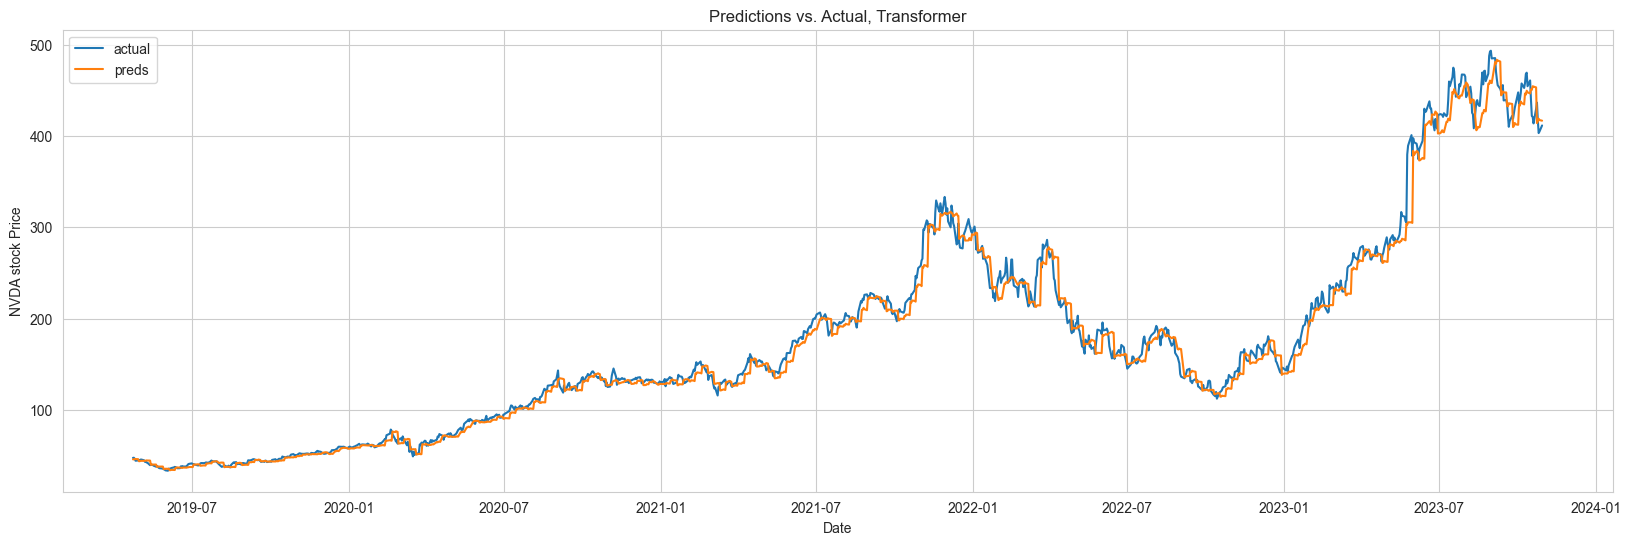

In [55]:
plot_results(data.test, transformer_preds.predictions, data.df, title_suffix='Transformer')

In [54]:
data.test[0:]

array([[[ 45.86758423],
        [ 46.73924255],
        [ 46.51078415],
        [ 46.26491928],
        [ 46.80381393]],

       [[ 47.35015488],
        [ 47.47431946],
        [ 46.41640091],
        [ 44.22608948],
        [ 44.53401184]],

       [[ 44.94874191],
        [ 44.81712341],
        [ 45.49259949],
        [ 45.44789505],
        [ 44.66316223]],

       ...,

       [[457.98001099],
        [468.05999756],
        [469.45001221],
        [454.60998535],
        [460.95001221]],

       [[439.38000488],
        [421.95999146],
        [421.01000977],
        [413.86999512],
        [429.75      ]],

       [[436.63000488],
        [417.79000854],
        [403.26000977],
        [405.        ],
        [411.60998535]]])

In [56]:
test = data.test
preds = transformer_preds.predictions
plot_test = test[1:]
plot_preds = preds[1:]
# x = df[-(plot_test.shape[0]*plot_test.shape[1]):].index
plot_test = plot_test.reshape((plot_test.shape[0]*plot_test.shape[1], 1))
plot_preds = plot_preds.reshape((plot_test.shape[0]*plot_test.shape[1], 1))

In [64]:
rmse = np.sqrt(((plot_test - plot_preds) ** 2).mean())
print(rmse)

12.546236965064642


In [65]:
data.X_test

array([[[ 45.86758423],
        [ 46.73924255],
        [ 46.51078415],
        [ 46.26491928],
        [ 46.80381393]],

       [[ 46.73924255],
        [ 46.51078415],
        [ 46.26491928],
        [ 46.80381393],
        [ 47.35015488]],

       [[ 46.51078415],
        [ 46.26491928],
        [ 46.80381393],
        [ 47.35015488],
        [ 47.47431946]],

       ...,

       [[454.60998535],
        [460.95001221],
        [439.38000488],
        [421.95999146],
        [421.01000977]],

       [[460.95001221],
        [439.38000488],
        [421.95999146],
        [421.01000977],
        [413.86999512]],

       [[439.38000488],
        [421.95999146],
        [421.01000977],
        [413.86999512],
        [429.75      ]]])